In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

plot_save_dir = "/global/homes/v/virajvm/galaxy_image_prior/paper_1"


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs, process_img
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb, get_scrollable_pdfs
from desi_lowz_funcs import find_objects_nearby, print_radecs
# from construct_dwarf_galaxy_catalogs import process_sga_matches

import warnings
from astropy.wcs import FITSFixedWarning

# Suppress just FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)


%load_ext autoreload
%autoreload 2

# python3 desi_dwarfs/code/dwarf_photo_pipeline.py -sample SGA -min 0 -max 100000 -run_parr -ncores 1 -overwrite -nchunks 1 -no_cnn_cut -use_sample sga -run_aper -run_cog -tgids 39628500637844206


def get_vi_pdf(cat_vi, name, png_type = "cog"):
    
    all_sga_outlier_files = []
    
    for i in range(len(cat_vi)):
        bool_type = cat_vi["ISOLATE_MASK_LIKELY_SHREDDING"].data[i]
        file_path = cat_vi["FILE_PATH"].data[i]
        if isinstance(file_path, bytes):
            file_path = file_path.decode()     
        else:
            pass  

        if png_type == "cog":
            if bool_type:
                #we use the no_isolate one
                file_i = os.path.join(file_path, "cog_summary_no_isolate.png")
            else:
                file_i = os.path.join(file_path, "cog_summary.png")

        else:
            file_i =  os.path.join(file_path, "grz_bands_segments.png")
  
        all_sga_outlier_files.append(file_i)


    get_scrollable_pdfs(all_sga_outlier_files, f"/pscratch/sd/v/virajvm/trash/{name}")


In [2]:
from isolate_galaxy_mask import get_isolate_galaxy_mask, make_custom_cmap
    
cmap_cstm = make_custom_cmap(8, cmap_name="tab10")

from consolidate_photometry import consolidate_new_photo, get_fastspec_matched_catalog


In [3]:
from sga_nsa_comp_funcs import make_compare_plot_3bands
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes

import cmasher as cmr

In [4]:
def do_consolidate(cat,sample):
    cat = consolidate_new_photo(cat,sample=sample)
    cat = consolidate_positions_and_shapes(cat)
    cat = cat[cat["PHOTO_MASKBIT"] == 0]
    return cat


In [5]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")


bgsb_cat = do_consolidate(bgsb_cat,"BGS_BRIGHT")
print("--"*10)
bgsf_cat = do_consolidate(bgsf_cat,"BGS_FAINT")
print("--"*10)
elg_cat = do_consolidate(elg_cat,"ELG")
print("--"*10)

lowz_cat = do_consolidate(lowz_cat,"LOWZ")
print("--"*10)

sga_cat = do_consolidate(sga_cat,"SGA")



Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.23503663526501095
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.058949
MASKBIT=2^2, bad resid, fraction : 0.0056
MASKBIT=2^3, cog curve decrease, fraction: 0.0096
MASKBIT=2^4, aperfrac-in image, fraction: 0.001047
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047007
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000333
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.048958
MASKBIT=2^11, no seg found, fraction: 0.000048
MASKBIT=2^13, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.5378247216671425
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=

100%|██████████| 21018/21018 [00:00<00:00, 220125.00it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.31032412965186074
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0096
MASKBIT=2^1, cog not converge, fraction: 0.082233
MASKBIT=2^2, bad resid, fraction : 0.0114
MASKBIT=2^3, cog curve decrease, fraction: 0.0066
MASKBIT=2^4, aperfrac-in image, fraction: 0.000300
MASKBIT=2^5, aperfrac-mask image, fraction: 0.124850
MASKBIT=2^6, image-frac mask, fraction: 0.000900
MASKBIT=2^7, bad colors, fraction: 0.000600
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.110444
MASKBIT=2^10, aper-cen masked, fraction: 0.110144
MASKBIT=2^11, no seg found, fraction: 0.000300
MASKBIT=2^13, near sga outskirts, fraction: 0.006603
Fraction of sources where org trac is likely good = 0.4627

100%|██████████| 3332/3332 [00:00<00:00, 205276.38it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------


Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.1954395474899835
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1824
MASKBIT=2^1, cog not converge, fraction: 0.033879
MASKBIT=2^2, bad resid, fraction : 0.0025
MASKBIT=2^3, cog curve decrease, fraction: 0.0014
MASKBIT=2^4, aperfrac-in image, fraction: 0.000334
MASKBIT=2^5, aperfrac-mask image, fraction: 0.195204
MASKBIT=2^6, image-frac mask, fraction: 0.001355
MASKBIT=2^7, bad colors, fraction: 0.001375
MASKBIT=2^8, source not on segment, fraction: 0.0041
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.045997
MASKBIT=2^10, aper-cen masked, fraction: 0.017244
MASKBIT=2^11, no seg found, fraction: 0.029991
MASKBIT=2^13, near sga outskirts, fraction: 0.005617
Fraction of sources where org trac is likely good = 0.19938722601932596
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=

/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/consolidate_photometry.py:359: RuntimeWarning: overflow encountered in double_scalars
  return r0 * (numerator / denominator)**(1/alpha_2)
100%|██████████| 50916/50916 [00:00<00:00, 217397.51it/s]


Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------
Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.5029171528588098
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0070
MASKBIT=2^1, cog not converge, fraction: 0.185531
MASKBIT=2^2, bad resid, fraction : 0.0023
MASKBIT=2^3, cog curve decrease, fraction: 0.0093
MASKBIT=2^4, aperfrac-in image, fraction: 0.000000
MASKBIT=2^5, aperfrac-mask image, fraction: 0.024504
MASKBIT=2^6, image-frac mask, fraction: 0.000000
MASKBIT=2^7, bad colors, fraction: 0.000000
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.099183
MASKBIT=2^10, aper-cen masked, fraction: 0.019837
MASKBIT=2^11, no seg found, fraction: 0.000000
MASKBIT=2^13, near sga outskirts, fraction: 0.002334
Fraction of sources where org trac is likely good = 0.50525

100%|██████████| 857/857 [00:00<00:00, 273222.75it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
--------------------


Added PCNN values!
FRACTION REVERT BACK TO TRACTOR: 0.24194309070900802
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0009
MASKBIT=2^1, cog not converge, fraction: 0.028297
MASKBIT=2^2, bad resid, fraction : 0.0017
MASKBIT=2^3, cog curve decrease, fraction: 0.0033
MASKBIT=2^4, aperfrac-in image, fraction: 0.005659
MASKBIT=2^5, aperfrac-mask image, fraction: 0.001886
MASKBIT=2^6, image-frac mask, fraction: 0.000314
MASKBIT=2^7, bad colors, fraction: 0.000629
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.022324
MASKBIT=2^10, aper-cen masked, fraction: 0.005188
MASKBIT=2^11, no seg found, fraction: 0.000000
Fraction of sources where org trac is likely good = 0.3903474296494262
Updating the maskbits to reflect some objects reverted to original Tractor photometry
MASKBIT=2^0, cog nan mask, 0.0009
MASKBIT=2^7, bad colors, fr

100%|██████████| 6361/6361 [00:00<00:00, 182457.07it/s]

Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column


In [6]:
# --- remove extra columns from SGA before stacking ---
extra_cols = set(sga_cat.colnames) - set(lowz_cat.colnames)
if extra_cols:
    print(f"Removing {len(extra_cols)} extra columns from SGA: {extra_cols}")
    sga_cat.remove_columns(list(extra_cols))

# optional: reorder columns to match LOWZ (keeps order consistent)
sga_cat = sga_cat[lowz_cat.colnames]

tot_shred = vstack([ bgsb_cat, bgsf_cat, lowz_cat, elg_cat, sga_cat])



Removing 15 extra columns from SGA: {'SGA_SMA_SB26', 'SGA_GR', 'SGA_LOGM_SAGA', 'SGA_DEC_MOMENT', 'SGA_ZRED_LEDA', 'SGA_R_COG_MAG', 'SGA_G_COG_MAG', 'SGA_BA', 'SGA_MAG_LEDA', 'SGA_SMA_SB25', 'SGA_RA_MOMENT', 'SGA_Z_COG_MAG', 'SAMPLE_DESI', 'SGA_PA', 'SGA_ID'}


In [45]:
tot_shred[tot_shred["TARGETID"]==39628307825691449]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-240p020-250p025/2422p220/BGS_BRIGHT_tgid_39628307825691449

In [7]:
len(tot_shred)

67359

In [8]:
#also read in the nsa catalog
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")


In [14]:
from sga_nsa_comp_funcs import get_nsa_matching

nsa_mag_all, best_mag_all, nsa_trac_mag, nsa_ff_all, desi_nsa_match_cat, nsa_match_cat = get_nsa_matching(nsa_cat, tot_shred)


11900
11554


In [22]:
# # match_tgids = [39628138115762807, 39628242226776575, 39628343561161817, 39628376708745386]
# # better_tgids =  [39627761270130297, 39627719486473819, 39632976304146316, 39627873182548501]
# # worse_tgids = [ 39633324834032193, 39627915440163235, 39633489556931574, 39627696413606604 ]

match_tgids = [39627702776366521, 39627841343589611, 39627708749055631,39627601450375402,39627670568313160    ]
match_cutouts = [45,75,40,75,40]

match_tgids_p2 = [39628302134019652, 39627634593760082 ]
match_cutouts_p2 = [120,120 ]

better_tgids_top  = [39633182894589308, 39628268013357910, 39627763585388280, 39627679288266127, 39633358820476651,  39627756916443987]
better_cutouts_top = [140, 140, 45, 110,45, 90]

better_tgids_bot  = [39627697294412009, 39627929444942465, 39627703179023326, 39627697306992959, 39627703279686739]
better_cutouts_bot = [25, 25, 25, 25, 25]

better_tgids = better_tgids_bot + better_tgids_top
better_cutouts = better_cutouts_bot + better_cutouts_top

better_tgids_p2 = [ 39633318706153500,39627785555151004, 39627809517213943 , 39627997602383858, 39633153945502066]
better_cutouts_p2 = [75, 90, 50, 60, 90]


worse_tgids = [39627738985794919, 39628135691457089, 39628307825691449, 39628519919060183, 39633208593090958]
worse_cutouts  = [120, 140,75, 75, 75 ] 

ambi_tgids = [39627754362113195,  39627836813739445, 39633195536222566, 39628111796507282, 39627848981419490, 39627836750824798,]
ambi_cutouts = [80, 80, 45, 60, 90, 80]

# nsa_bad_tgids_paper = [39627658979442966, 39627709944432012, 39627663320547970, 39627643640878867, 39627793792766271, 39627889687135617, 39627503219771992, 39627672954867965, 39627720946092125, 39627733398983952, 39627739707214817, 39627745226918247]
# nsa_better_tgids_paper = [39633207930390678, 39628459877597639, 39627945148416047, 39627936113885462, 39627652578936400 ]

#combine this all in a dict
all_tgids = match_tgids + better_tgids + worse_tgids + ambi_tgids + match_tgids_p2 + better_tgids_p2
all_cutouts = match_cutouts + better_cutouts + worse_cutouts + ambi_cutouts + match_cutouts_p2 + better_cutouts_p2

cutout_size_dict = {}
for i,tgidi in enumerate(all_tgids):
    cutout_size_dict[tgidi] = all_cutouts[i]


In [29]:
plot_save_dir = "/global/homes/v/virajvm/galaxy_image_prior/paper_1"


In [23]:
from sga_nsa_comp_funcs import plot_one_panel_model_comp

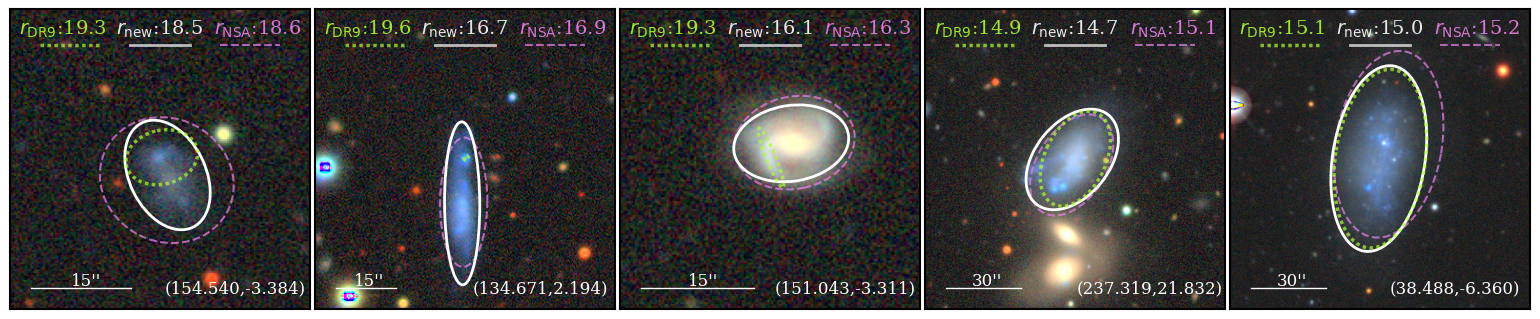

In [39]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(3):

    plot_one_panel_model_comp([ax[i]],match_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ match_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)


for i in range(2):
    plot_one_panel_model_comp([ax[i+3]],match_tgids_p2[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ match_tgids_p2[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=30,bar_size_str="30''", compare_sga=False)

plt.savefig(f"{plot_save_dir}/plots/nsa_match_comparison.png",bbox_inches="tight")

plt.show()

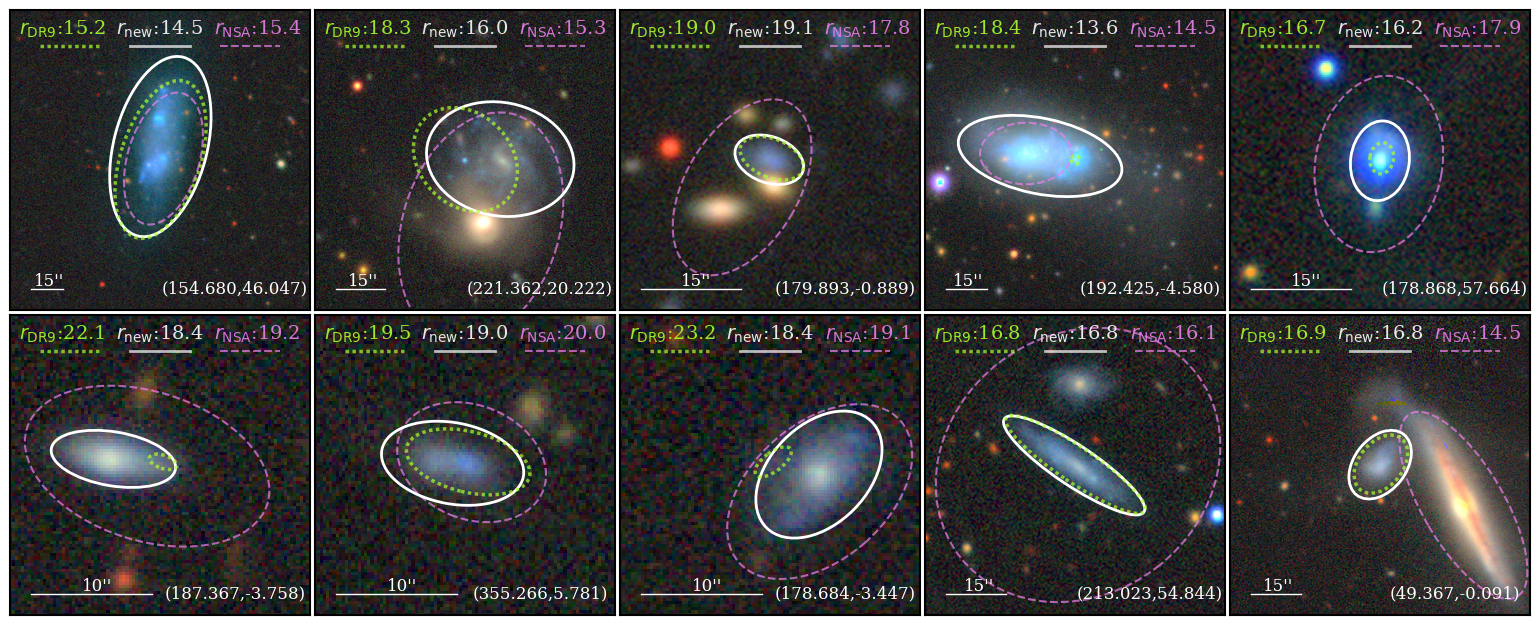

In [40]:
ax = make_subplots(ncol=5,nrow=2,col_spacing=0.05,plot_size=3,row_spacing=0.05)

for i in range(5,10):

    plot_one_panel_model_comp([ax[i]],better_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)


for i in range(3):

    plot_one_panel_model_comp([ax[i]],better_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=10,bar_size_str="10''", compare_sga=False)




for i in range(2):
    plot_one_panel_model_comp([ax[i+3]],better_tgids_p2[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ better_tgids_p2[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)



plt.savefig(f"{plot_save_dir}/plots/nsa_better_comparison.png",bbox_inches="tight")

plt.show()

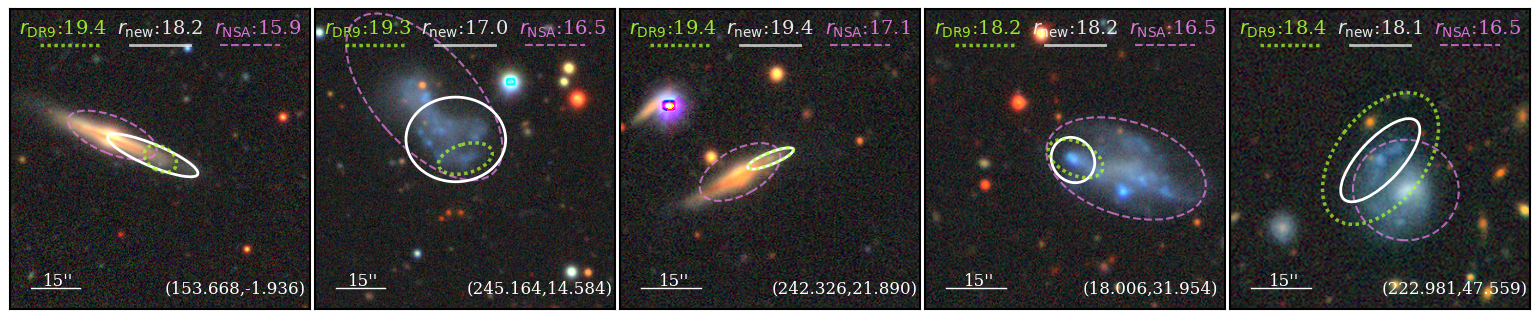

In [41]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],worse_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ worse_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)
    

plt.savefig(f"{plot_save_dir}/plots/nsa_worse_comparison.png",bbox_inches="tight")

plt.show()

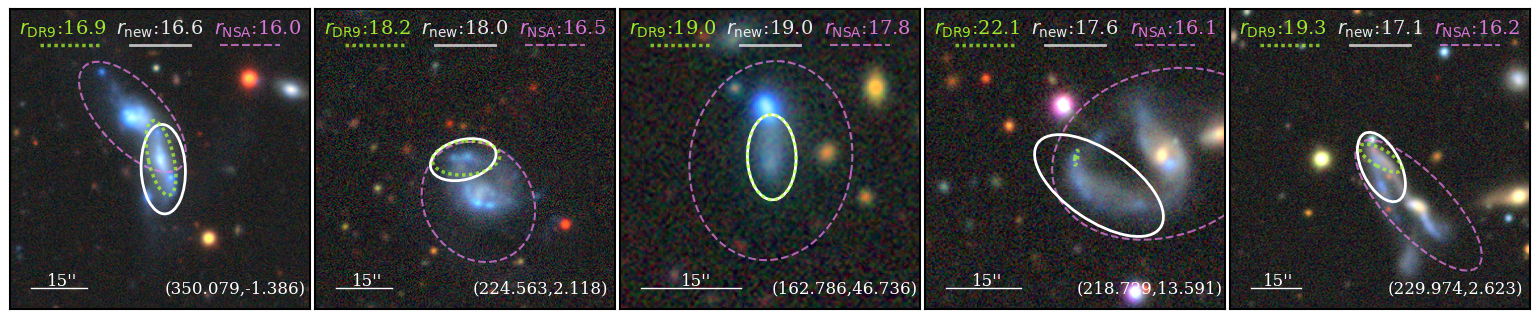

In [42]:
ax = make_subplots(ncol=5,nrow=1,col_spacing=0.05,plot_size=3)

for i in range(5):

    plot_one_panel_model_comp([ax[i]],ambi_tgids[i], desi_nsa_match_cat, nsa_match_cat,
                                 alpha=0.7,linewidth=2,
                                 sga_ls = "--",sga_color = "violet",
                                 new_ls = "-", new_color = "white",
                                  trac_ls  = (0,(1,1)), trac_color="greenyellow",
                                 scale_f = 2, cutout_size_arcsec = cutout_size_dict[ ambi_tgids[i] ],
                                verbose=False,use_sga_r50=True,
                                 bar_size_arc=15,bar_size_str="15''", compare_sga=False)
    

plt.savefig(f"{plot_save_dir}/plots/nsa_ambi_comparison.png",bbox_inches="tight")

plt.show()